# Symantic Segmentation Using U-NET Architechture

---
<p style="text-align: justify">
Image segmentation is the process of being able to make a mask/predict the pixels where the object of attention lies.</p>

<p style="text-align: justify">
Symantic Segmentation is a technique in which we assign a class to every pixel present in the image. There are two ways to go about this we could either classify each object on the image separately which is called instance segmentation or we could just classify all objects as 1 and the background as 0 which gives a mask.</p>

<p style="text-align: justify">
Symentic segmentation is a method mainly dependent on features it can pick up from an image to classify it. These features are recognized with the use of convolutional neural networks.
The usual architecture that is followed is that there will be an encoder followed by a decoder. Such an architecture is used because our output needs to be of the same size as that of our input. But while applying convolutional layers we change that like when we use the maxpooling layer we downsample the image. This process of downsampling is called an encoder. While the reverse is called a decoder where we upsample the image.</p>
    
<p style="text-align: justify">
Also when we are carrying out symantic segmentation our last layer is not a dense layer likes which normally used in classification problems. Instead, it is a single image like mentioned above.
</p>

---

Many methods exist to carry out the task of image segmentation. Out of those, there were two that particularly stood out:-
- <p style="text-align: justify">U-NET: designed for Biomedical image segmentation. Their approach was very novel, and the structure of the architecture was intriguing. And it solved a very grave problem in the biomedical domain, which was the lack of sample images used for training. This method compensates for the lack through heavy use of data augmentation.</p>
- <p style="text-align: justify">PSP Net: This is a method that is used to get an understanding of the image as a whole also known as scene parsing. And as its name suggests <mark>(Pyramid Scene parsing network)</mark> has its architecture structured in a pyramid shape.</p>

I chose the U-NET Architecture mainly because:
- <p style="text-align: justify">I found the structure of the architecture very fascinating and it got my attention and my will to gain a better understanding of it. Mainly the data argumentation part where they concatenate layers from the encoder part to the decoder part to compensate for the data loss.</p>
- <p style="text-align: justify">This technique tackles exactly the kind of problem statement we have at hand. And it deals with the problem in a rather interesting manner where the use of the training data required to achieve a good result was little(for reference I used only 10% of the image sample provided. Out of that 10%, 20% of the images were used to validate the model whereas the other 80 were used to truly train the model.</p>

<p style="text-align: justify">The problem that I have identified in U-NET is that it ends up <strong>loosing a lot of its data when down sampling and upsampling </strong> . And this is mainly due to the method used to downsample ie. Maxpooling. I have chosen to change the downsampling method to avrage pooling to help overcome that problem. I have also used an additional metric known as mean IOU these are disscussed in more detail bellow.</p>

In [2]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
print("Num GPU's available:",len(tf.config.experimental.list_physical_devices('GPU')))


Num GPU's available: 1


In [3]:
#Defining the basic prams
IMG_WIDTH,IMG_HEIGHT=128,128
IMG_CHANNELS=3

Resizing training images and masks


100%|██████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:10<00:00, 96.18it/s]


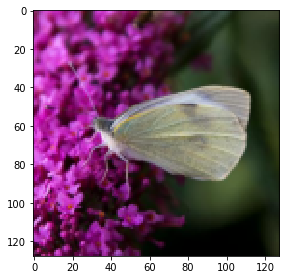

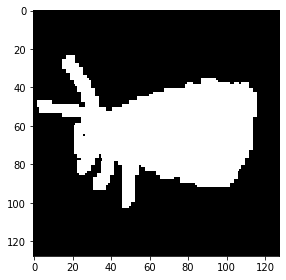

In [4]:
TRAIN_PATH_X = './Data/DUTS-TR-Image/'
percent=0.1
train_ids_X = next(os.walk(TRAIN_PATH_X))[2]
train_ids_X=train_ids_X[:int(percent*len(train_ids_X))]
TRAIN_PATH_y = './Data/DUTS-TR-Mask/'
train_ids_y = next(os.walk(TRAIN_PATH_y))[2]
train_ids_y=train_ids_y[:int(percent*len(train_ids_y))]
#initialising empty arrays
X = np.zeros((len(train_ids_X), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids_y), IMG_HEIGHT, IMG_WIDTH,1), dtype=bool)
#resizing and storing images for X and y
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids_X), total=len(train_ids_X)):   
    path = TRAIN_PATH_X + id_
    img=imread(path)[:,:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
for n, id_ in tqdm(enumerate(train_ids_y), total=len(train_ids_y)):   
    path = TRAIN_PATH_y + id_
    img=imread(path,as_gray=True)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    y[n] = img  #Fill empty X_train with values from img
#printing random samples to check
image_x = random.randint(0, len(train_ids_X))
imshow(X[image_x])
plt.show()
imshow(np.squeeze(y[image_x]))
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

## Defining the CNN

We will follow the folling architechture

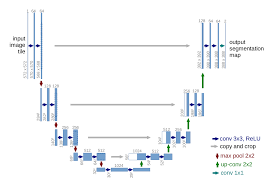

here we can clearly see that we have a set of convulution layers followed by a maxpooling layer

After each set the image dimentions decrease but the number of features increase this part of UNET is the encoder.

The lowest layer being the 5th having image of only 8x8 but the features being 256

From then on the decoder part starts:

where instad of downscaling we upscale the image and the number of features reduce

As we can also observe that there is an additional conncatenation of the layer having simmilar dimentions where the previously computed results help and mainly reduce the need of training data.
(Note: we are also droping data at each step to avoid overfitting)



#### Input Layer
Here we have defined the input layer and we have converted the 8-bit data in the format we require that is floating point as the convuluted layer takes in floating point values as input.

In [6]:
inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))#defining the input layer which will idealy be 128,128,3
s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)#converting input to floating point as needed for the model

### Encoder

#### 1st  set of convulution layer
Our first set convulotional layer has a feature dimention of 16, our kernal is of (3,3), we use the 'relu' activaion funcion. We initialize our weights using the kernal initializer 'he_normal' which just means that our ditribution is going to be a truncated normal distribution centered around 0.
We also want to have a padding that makes sure that our output image has same dimentions as input we use the parameter padding and set it as 'same'
We also drop 10% of the data from our c1 layer to avoid overfitting 

Each Set of covolution layer is followed by Average Pooling.

This process kind of accumlates the result by taking the average value over an input window in our case it is going to be a 2x2 and downsample the image.

This step helps mainly giving our model the genral idea of what pixel values that region of the image has but not all the pixels present. This is highly benificial as not only does it reduce the amout of data we need to pass to our neral network hence enhancing training efficiency, it also makes sure that our model does not over fit our traing data.

In [7]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

In [8]:
p1 = tf.keras.layers.AveragePooling2D((2, 2))(c1)

In [9]:
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.AveragePooling2D((2, 2))(c2)

In [10]:
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.AveragePooling2D((2, 2))(c3)

In [11]:
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c4)

In [12]:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

### Decoder

In [13]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

In [14]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

In [15]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

In [16]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

The output is not a dense layer as a CNN would normaly have but is only a single output as we need an image and not multiple class values as output

In [17]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

The Adam optimizer is chosen as it is optimal when the data/parameters are larger in number like in our case we have many params. The metrics observed are accuracy and the mean Intersection-Over-Union metric.

Which follows the following formula:

iou = true_positives / (true_positives + false_positives + false_negatives)

The mean Intersection over Union metric is chosen because it checks which pixels in output mask and the true mask overlap and genrate a value using above formula this will be paticularly helpful because our pixels are having a value of only 1 or 0 hence this method gives a clear answer.

In [18]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
#model checkpoint
callbacks=[
    tf.keras.callbacks.ModelCheckpoint('Model_for_UNET.h5',verbose=1,save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]
results=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=16,epochs=25,callbacks=callbacks)

Epoch 1/25
53/53 [==============================] - 17s 202ms/step - loss: 0.5491 - accuracy: 0.7443 - mean_io_u: 0.3668 - val_loss: 0.4361 - val_accuracy: 0.8045 - val_mean_io_u: 0.3642

Epoch 00001: val_loss improved from inf to 0.43607, saving model to Model_for_UNET.h5
Epoch 2/25
53/53 [==============================] - 5s 99ms/step - loss: 0.3949 - accuracy: 0.8293 - mean_io_u: 0.3668 - val_loss: 0.3887 - val_accuracy: 0.8365 - val_mean_io_u: 0.3642

Epoch 00002: val_loss improved from 0.43607 to 0.38867, saving model to Model_for_UNET.h5
Epoch 3/25
53/53 [==============================] - 6s 106ms/step - loss: 0.3370 - accuracy: 0.8575 - mean_io_u: 0.3668 - val_loss: 0.3275 - val_accuracy: 0.8641 - val_mean_io_u: 0.3642

Epoch 00003: val_loss improved from 0.38867 to 0.32754, saving model to Model_for_UNET.h5
Epoch 4/25
53/53 [==============================] - 6s 111ms/step - loss: 0.3081 - accuracy: 0.8702 - mean_io_u: 0.3668 - val_loss: 0.2977 - val_accuracy: 0.8762 - val_mean_

In [20]:
model.save_weights("Weights.h5")

In [21]:
idx = random.randint(0, len(X_train))

In [22]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

7/7 [==============================] - 1s 171ms/step


In [23]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

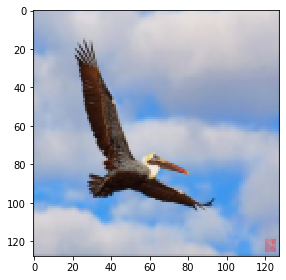

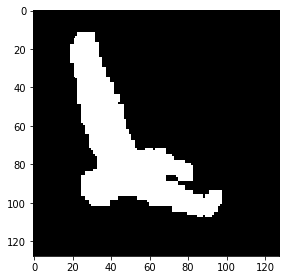

C:\Users\hansi\anaconda3\envs\Deep_Learning\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


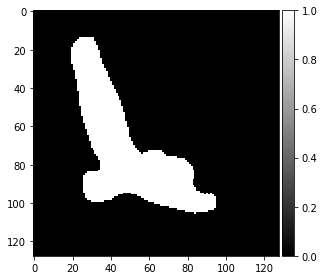

In [24]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
# print(preds_train_t[ix])
plt.show()

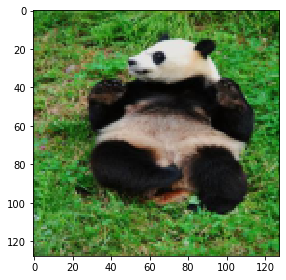

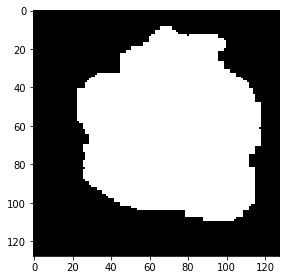

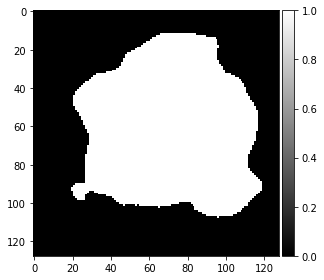

In [25]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
# imshow(np.squeeze(preds_val_t[ix]))
imshow(preds_val_t[ix],cmap='gray')
plt.show()

References:

https://www.youtube.com/watch?v=azM57JuQpQI -Image Segmentation using U-Net - Part1 (What is U-net?)-DigitalSreeni

https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28 U-Net: Convolutional Networks for Biomedical Image Segmentation

https://www.v7labs.com/blog/semantic-segmentation-guide: The Beginner’s Guide to Semantic Segmentation

## Conclusion:
The UNET Architecture is a brilliant architecture it may not give highly accurate results in its current form but has a lot of potential to improve. I initally wanted to use the pyramid architecture's strong points and merge them with UNET to improve result but I took more time then expected to implement UNET itself. The more challenging part was getting the data set up. I also had some issues to run the model as I initally did not know how to run it on a GPU and it took around 1 hr only to fail. I figured out how to use the GPU later and improved the training time to a few minutes.
I am very greatful Comet spaces for granting me this opportunity. I have learnet a lot and it was an exprience which will change the way I learn for the  rest of my life. This was only and entrance assignment but it was so insightfull. I am looking forward to to opportunities of learning available once I can join thank you for this life changing opportunity.